<a href="https://colab.research.google.com/github/Michael-David-Lam/NLP-Final-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries/Dependencies Installation

In [2]:
# !pip install datasets
# !pip install gensim
# !pip install --upgrade numpy gensim
# !pip install tensorflow
# !pip install seqeval
# !pip uninstall -y torch torchtext
# !pip install torch==2.0.1 torchtext==0.15.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16164 sha256=f8c06d192c4f10aaa33bb3b3e09219b34337b44f536610895574e15195570b89
  Stored in directory: /Users/darren/Library/Caches/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Successfully uninstalled torch-2.4.1
  Obtaining dependency information for torch==2.0.1 from https://files.pythonhosted.org/packages/85/68/f901437d3e3ef6fe97adb1f372479626d994185b8fa06803f5bdf3bb90fd/torch-2.0.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchtext==0.15.2 from https://files.pythonhosted.org/packages/59/e9/1d3ecd04ef057277ba7e3ad0b8793f0d161b60a4ba7fe0b9aa6870a498e4/torchtext-0.15.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining depe

# Setup 1 (Word2Vec)

In [51]:
from datasets import load_dataset
import pandas as pd
from gensim.models import Word2Vec
import ast
from gensim.models import KeyedVectors
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from seqeval.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import string
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [53]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [54]:
#To combine train,test,split for vectorisation to build a rich embedding space

import ast

def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

In [55]:
#List of Parameters (Just using Lab as reference)
num_features = 300
min_word_count = 1
num_workers = 2
window_size = 3
subsampling = 1e-3

In [56]:
w2v_model = Word2Vec(
    sentences=all_tokens,
    vector_size=num_features,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers,
    sample=subsampling
)

In [57]:
vocab = w2v_model.wv.index_to_key
word_index = {word: idx + 1 for idx, word in enumerate(vocab)}

embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [58]:
all_lengths = [len(seq) for seq in train_tokens + val_tokens + test_tokens]

print(max(all_lengths))
print(np.mean(all_lengths))
print(np.percentile(all_lengths, 90))
#likelihood to chose 76 to get the best balance of computational power + covers 90% of sequence

371
41.17041666666667
76.0


In [59]:
# Encode as Bi-LSTM requires numbers to process

def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [60]:
all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)

In [61]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input, model)
model.summary()

/Users/darren/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 76, 300)   │  4,947,600 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 76)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 76, 256)   │    439,296 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 76, 4)     │      1,028 │ bidirectional_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,387,924 (20.55 MB)

 Trainable params: 5,387,924 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)

In [63]:
#Training of model (using Adam as a baseline optimiser)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.3890 - loss: 0.8189 - val_accuracy: 0.4096 - val_loss: 0.4819
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.4221 - loss: 0.4087 - val_accuracy: 0.4260 - val_loss: 0.3924
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.4590 - loss: 0.2478 - val_accuracy: 0.4327 - val_loss: 0.3628
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.4738 - loss: 0.1461 - val_accuracy: 0.4346 - val_loss: 0.3708
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4889 - loss: 0.0862 - val_accuracy: 0.4306 - val_loss: 0.4168
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.4920 - loss: 0.0568 - val_accuracy: 0.4254 - val_loss: 0.4991
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4908 - loss: 0.0387 - val_accuracy: 0.4277 - val_loss: 0.4985
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.5001 - loss: 0.0277 - val_accurac

In [64]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
F1 Score: 0.6437908496732027
              precision    recall  f1-score   support

          AC       0.74      0.72      0.73       741
          LF       0.48      0.56      0.52       455

   micro avg       0.63      0.66      0.64      1196
   macro avg       0.61      0.64      0.62      1196
weighted avg       0.64      0.66      0.65      1196



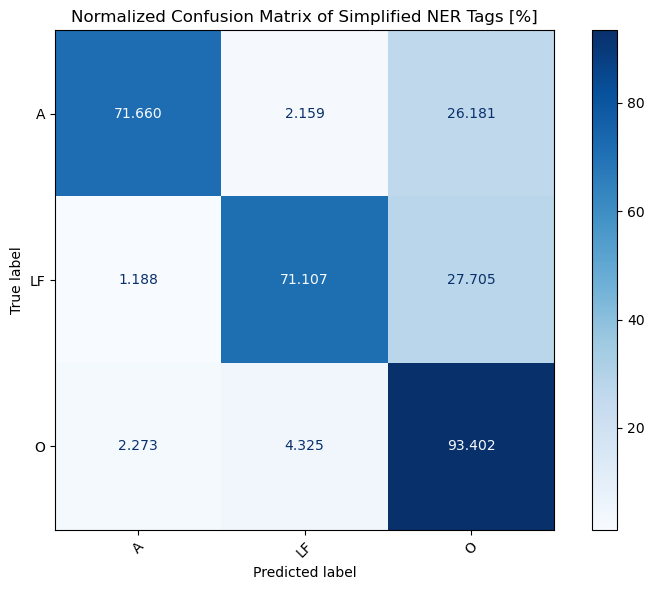

In [65]:

flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


# Set up 2 (Glove)

In [66]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [67]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [68]:
def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

In [69]:
from torchtext.vocab import GloVe


glove = GloVe(name='6B', dim=300)

In [70]:
vocab = set(token for sentence in train_tokens + val_tokens + test_tokens for token in sentence)
word_index = {word: i + 1 for i, word in enumerate(vocab)}

embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in glove.stoi:
        embedding_matrix[i] = glove[word].numpy()

In [71]:
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True
)

In [72]:
def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [73]:
all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)

In [74]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input, model)
model.summary()

/Users/darren/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 76, 300)   │  4,947,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 76)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 76, 256)   │    439,296 │ embedding_7[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 76, 4)     │      1,028 │ bidirectional_4[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,387,924 (20.55 MB)

 Trainable params: 5,387,924 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)

In [76]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.4041 - loss: 0.7267 - val_accuracy: 0.4146 - val_loss: 0.4189
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4310 - loss: 0.3443 - val_accuracy: 0.4275 - val_loss: 0.3529
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4526 - loss: 0.2466 - val_accuracy: 0.4340 - val_loss: 0.3371
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.4735 - loss: 0.1551 - val_accuracy: 0.4339 - val_loss: 0.3471
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.4755 - loss: 0.1002 - val_accuracy: 0.4327 - val_loss: 0.3766
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4946 - loss: 0.0636 - val_accuracy: 0.4327 - val_loss: 0.4110
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.4949 - loss: 0.0382 - val_accuracy: 0.4321 - val_loss: 0.4546
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.4970 - loss: 0.0283 - val_accuracy: 0.

In [77]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
F1 Score: 0.676973148901546
              precision    recall  f1-score   support

          AC       0.76      0.75      0.76       741
          LF       0.52      0.60      0.56       455

   micro avg       0.66      0.70      0.68      1196
   macro avg       0.64      0.68      0.66      1196
weighted avg       0.67      0.70      0.68      1196



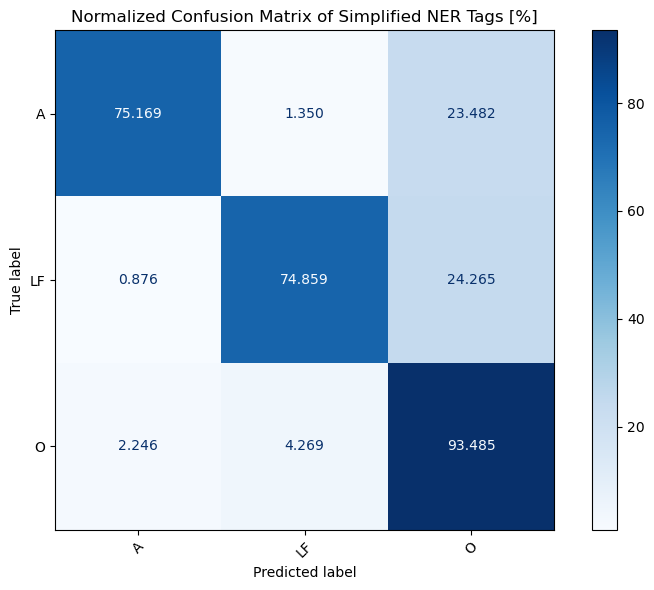

In [78]:

flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


# Set up 3 (Fast Text)

In [36]:
from torchtext.vocab import FastText

fasttext = FastText(language='en')

.vector_cache/wiki.en.vec: 6.60GB [18:06, 6.07MB/s]                             
100%|██████████████████████████████| 2519370/2519370 [01:54<00:00, 21954.82it/s]


In [37]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [38]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [39]:
#To combine train,test,split for vectorisation to build a rich embedding space

def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

Preparation of data (Creating vocab + embeding matrix from model itself)

In [40]:
vocab = set(token for sentence in train_tokens + val_tokens + test_tokens for token in sentence)
word_index = {word: i + 1 for i, word in enumerate(vocab)}

embedding_dim = fasttext.dim
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in fasttext.stoi:
        embedding_matrix[i] = fasttext[word].numpy()

In [41]:
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True
)


In [42]:
# Encode as Bi-LSTM requires numbers to process
def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [43]:
all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)

In [44]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input, model)
model.summary()


/Users/darren/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 76, 300)   │  4,947,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 76)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 76, 256)   │    439,296 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 76, 4)     │      1,028 │ bidirectional_2[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,387,924 (20.55 MB)

 Trainable params: 5,387,924 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)



In [46]:
#Training of model (using Adam as a baseline optimiser)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.3889 - loss: 0.8005 - val_accuracy: 0.4154 - val_loss: 0.4243
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.4265 - loss: 0.3423 - val_accuracy: 0.4305 - val_loss: 0.3468
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.4630 - loss: 0.2141 - val_accuracy: 0.4332 - val_loss: 0.3445
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.4729 - loss: 0.1284 - val_accuracy: 0.4329 - val_loss: 0.3567
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.4928 - loss: 0.0795 - val_accuracy: 0.4360 - val_loss: 0.3740
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.4882 - loss: 0.0515 - val_accuracy: 0.4342 - val_loss: 0.4282
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.5005 - loss: 0.0372 - val_accuracy: 0.4343 - val_loss: 0.4523
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.4920 - loss: 0.0256 - val_accurac

In [47]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
F1 Score: 0.6740924092409241
              precision    recall  f1-score   support

          AC       0.79      0.77      0.78       741
          LF       0.49      0.55      0.52       455

   micro avg       0.67      0.68      0.67      1196
   macro avg       0.64      0.66      0.65      1196
weighted avg       0.67      0.68      0.68      1196



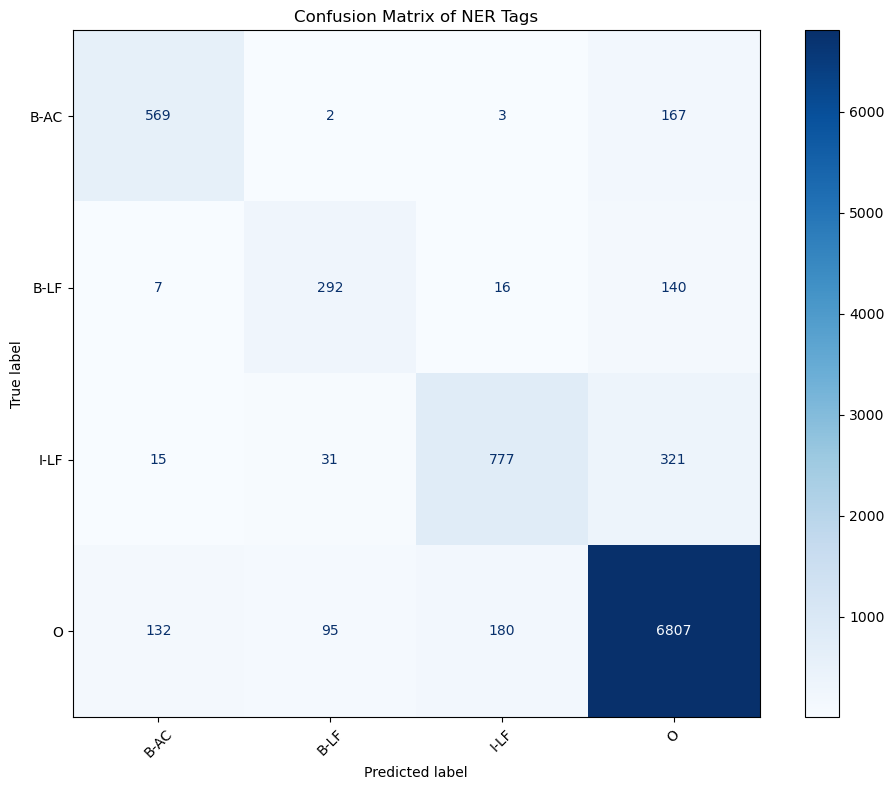

In [48]:
report_dict = classification_report(true_labels, pred_labels,output_dict=True)
class_keys = [key for key in report_dict.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in pred_labels for tag in seq]

flat_pred = flat_pred[:len(flat_true)]

unique_tags = sorted(set(flat_true + flat_pred))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(unique_tags)

y_true_encoded = le.transform(flat_true)
y_pred_encoded = le.transform(flat_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix of NER Tags")
plt.tight_layout()
plt.show()

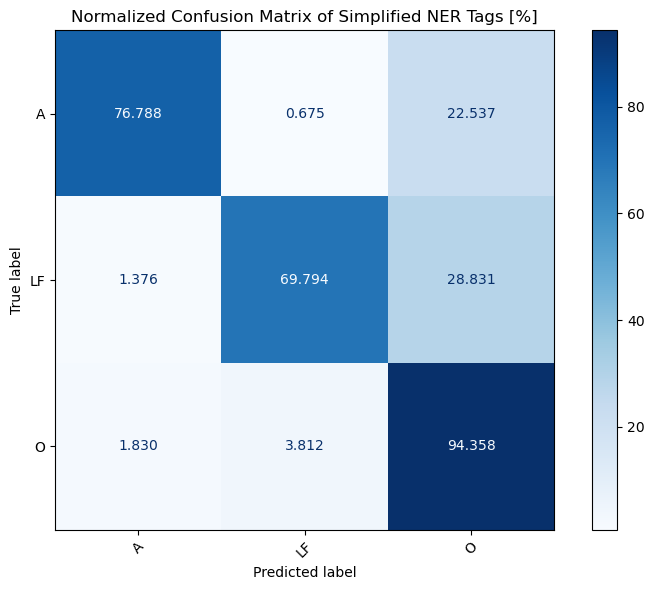

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()
